In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.nn.functional import normalize
from pretrain_autoencoders import SimpleAutoencoder
from data_loader_pretraining import RawDataLoader
from utils import RAW_BOTH_DATA_FOLDER, DATA_MODALITIES, CCLE_RAW_DATA_FOLDER, TCGA_DATA_FOLDER

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cpu


In [2]:
# Configuration
CELL_LATENT_DIM = 700
DRUG_LATENT_DIM = 50
ENCODER_CELL_PATH = "encoder_cell.pth"
ENCODER_DRUG_PATH = "encoder_drug.pth"
N_SAMPLES = 200

In [3]:
# Chargement des données brutes (cell + drug)
data_dict, _ = RawDataLoader.load_data(
    data_modalities=DATA_MODALITIES,
    raw_file_directory=RAW_BOTH_DATA_FOLDER,
    screen_file_directory=None,
    sep="\t"
)
X_cell_full, X_drug_full, cell_sizes, drug_sizes = RawDataLoader.get_unique_entities(data_dict)

Reading Raw Data Files...:   0%|                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:  33%|███████████████████                                      | 2/6 [00:26<00:52, 13.10s/it]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:   0%|                                                                 | 0/8 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning

In [4]:
# Chargement des modèles d'autoencodeurs
encoder_cell = SimpleAutoencoder(X_cell_full.shape[1], CELL_LATENT_DIM).to(device)
encoder_cell.load_state_dict(torch.load(ENCODER_CELL_PATH, map_location=device))
encoder_cell.eval()

encoder_drug = SimpleAutoencoder(X_drug_full.shape[1], DRUG_LATENT_DIM).to(device)
encoder_drug.load_state_dict(torch.load(ENCODER_DRUG_PATH, map_location=device))
encoder_drug.eval()

SimpleAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4257, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=4257, bias=True)
  )
)

In [5]:
# Conversion et normalisation des tenseurs
X_cell_tensor = normalize(torch.tensor(X_cell_full.values, dtype=torch.float32), dim=0).to(device)
X_drug_tensor = normalize(torch.tensor(X_drug_full.values, dtype=torch.float32), dim=0).to(device)

In [6]:
# Sous-échantillonnage indépendant pour cell et drug
cell_indices = torch.randperm(X_cell_tensor.shape[0])[:min(N_SAMPLES, X_cell_tensor.shape[0])]
drug_indices = torch.randperm(X_drug_tensor.shape[0])[:min(N_SAMPLES, X_drug_tensor.shape[0])]

X_cell_tensor_sample = X_cell_tensor[cell_indices]
X_drug_tensor_sample = X_drug_tensor[drug_indices]

In [7]:
# Encodage latent
with torch.no_grad():
    Z_cell = encoder_cell.encoder(X_cell_tensor).cpu().numpy()
    Z_drug = encoder_drug.encoder(X_drug_tensor).cpu().numpy()

print(Z_cell.shape)
print(Z_drug.shape)

(1355, 700)
(704, 50)


In [8]:
# t-SNE sur les données brutes
tsne_raw_cell = TSNE(n_components=2, random_state=42).fit_transform(X_cell_tensor.cpu().numpy())
tsne_raw_drug = TSNE(n_components=2, random_state=42).fit_transform(X_drug_tensor.cpu().numpy())

# t-SNE sur les données latentes
tsne_latent_cell = TSNE(n_components=2, random_state=42).fit_transform(Z_cell)

In [9]:
tsne_latent_drug = TSNE(n_components=2, random_state=42).fit_transform(Z_drug)

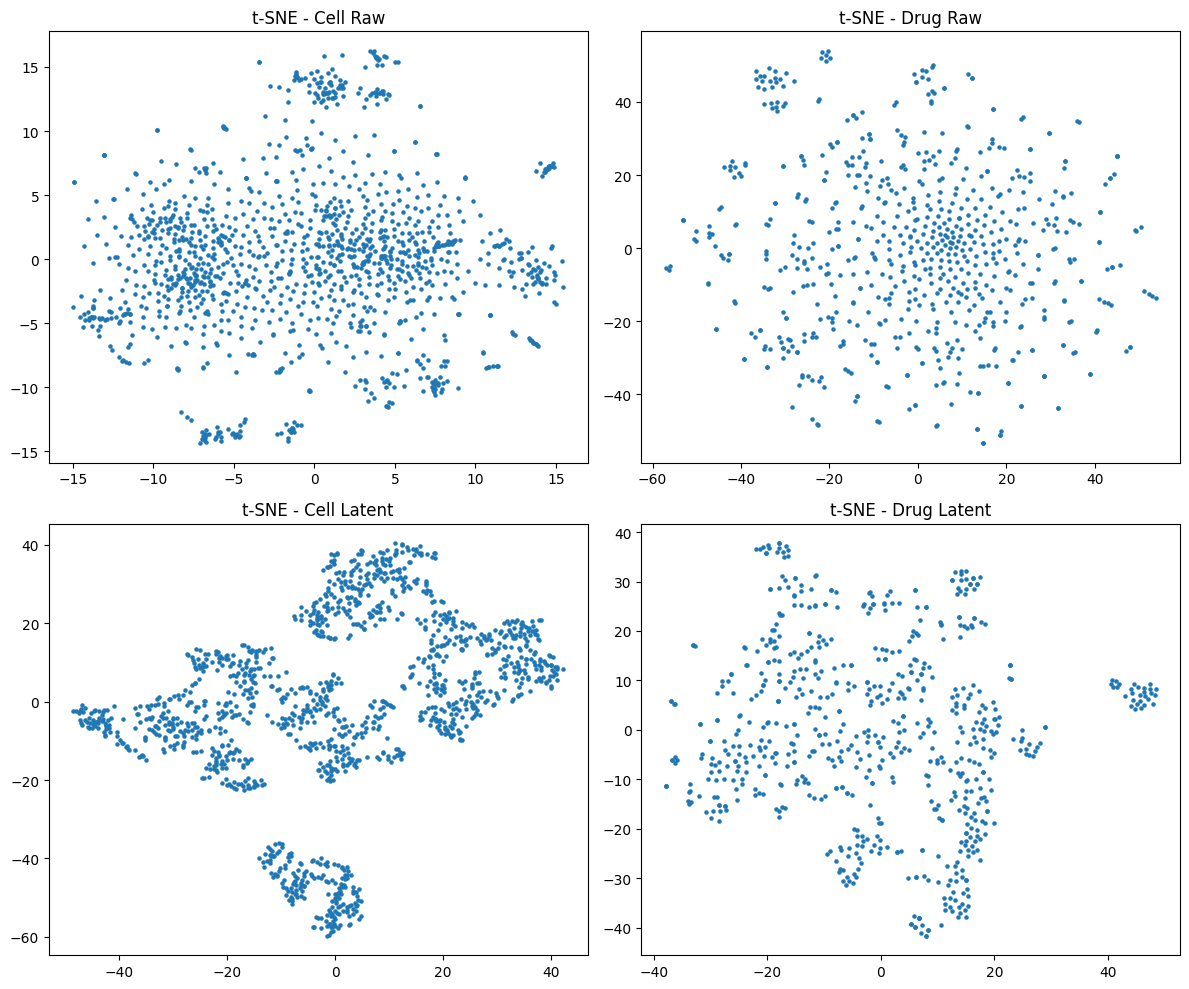

In [10]:
# Affichage
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].scatter(tsne_raw_cell[:, 0], tsne_raw_cell[:, 1], s=5)
axs[0, 0].set_title("t-SNE - Cell Raw")
axs[0, 1].scatter(tsne_raw_drug[:, 0], tsne_raw_drug[:, 1], s=5)
axs[0, 1].set_title("t-SNE - Drug Raw")
axs[1, 0].scatter(tsne_latent_cell[:, 0], tsne_latent_cell[:, 1], s=5)
axs[1, 0].set_title("t-SNE - Cell Latent")
axs[1, 1].scatter(tsne_latent_drug[:, 0], tsne_latent_drug[:, 1], s=5)
axs[1, 1].set_title("t-SNE - Drug Latent")
plt.tight_layout()
plt.show()